In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
import sys
PATH_TO_REPO = "/home/bis/2021_SJH_detectability/Detectability/compareModel/2021ACS_DeepDigest/"
sys.path.append(PATH_TO_REPO)

In [3]:
import time
start = time.time()
import read_protein_sequences
import cut_and_gene_tradata
import predictor
import sys
import getopt

# digestibility check data

In [4]:
df_aaindex = pd.read_csv('../data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

df_detect_peptide_train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test = test.loc[test.ID==1].reset_index(drop=True)
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

def get_data_labelEnc(df):
    label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
    label_enc['Z']=0
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYV'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[label_enc[aa] for aa in seq] + [0]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[label_enc[aa] for aa in seq]
               for seq in df.En.values]
    ec_data = [[label_enc[aa] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(31)]
               for seq in df.E1.values]
    e2_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(31)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
print(label_enc)

aa_train, pep_train, en_train, ec_train, e1_train, e2_train, y_train = get_data_labelEnc(train)
aa_val, pep_val, en_val, ec_val, e1_val, e2_val, y_val = get_data_labelEnc(val)
aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data_labelEnc(test)
print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, y_train.shape)
print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, y_val.shape)
print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(19, 21)
{'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20}
(543784, 39) (543784, 30) (543784, 31) (543784, 31) (543784, 31) (543784, 31) (543784,)
(135946, 39) (135946, 30) (135946, 31) (135946, 31) (135946, 31) (135946, 31) (135946,)
(67100, 39) (67100, 30) (67100, 31) (67100, 31) (67100, 31) (67100, 31) (67100,)


In [5]:
from tensorflow.keras.models import model_from_json
import time
import re

print("Loading model...")
protease='Trypsin'
s3 = time.time()
# load architecture
json_file = open(PATH_TO_REPO+'%s.json'%protease, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load parameters
loaded_model.load_weights(PATH_TO_REPO+'%s.h5'%protease)
e3 = time.time()
print("Time cost of loading model was %s seconds."%(e3-s3))

Loading model...
Time cost of loading model was 0.2991364002227783 seconds.


In [6]:
test['E1'] = test.E1.apply(lambda x: x.replace('-', 'Z'*31))
test['E2'] = test.E2.apply(lambda x: x.replace('-', 'Z'*31))

en = pd.DataFrame([[ts, 1] for ts in test.En.values], columns=['mers', 'label'])
ec = pd.DataFrame([[ts, 1] for ts in test.Ec.values], columns=['mers', 'label'])
e1 = pd.DataFrame([[ts, 0] for ts in test.E1.values], columns=['mers', 'label'])
e2 = pd.DataFrame([[ts, 0] for ts in test.E2.values], columns=['mers', 'label'])
df_mers = pd.concat([en, ec, e1, e2], axis=0).reset_index(drop=True)

print("Predicting! Please wait...")
s4 = time.time()
mers = df_mers.mers.values

X_test = np.array(predictor.coding(mers))
probas = loaded_model.predict(X_test)
proba = [p[0] for p in probas]

end = time.time()

Predicting! Please wait...


In [7]:
df_mers['proba'] = proba

In [27]:
test.head(2)

,peptide,En,Ec,E1,E2,protein,PEP,ID
0,K.ECGKAFSWGSSLVK.H,SQHQKIHTGEKPFECKECGKAFSWGSSLVKH,CKECGKAFSWGSSLVKHERVHTGEKSHECKE,KIHTGEKPFECKECGKAFSWGSSLVKHERVH,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ,sp|Q8N7M2|ZN283_HUMAN,ECGKAFSWGSSLVK,1
1,R.SPFSGTMTVDGNK.N,TLGYRMVHPSLLKSSRSPFSGTMTVDGNKNS,SSRSPFSGTMTVDGNKNSPADTCVEEDATVL,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ,sp|Q9H7U1|CCSE2_HUMAN,SPFSGTMTVDGNK,1


In [26]:
df_mers.head(2)

,mers,label,proba
0,SQHQKIHTGEKPFECKECGKAFSWGSSLVKH,1,0.036479
1,TLGYRMVHPSLLKSSRSPFSGTMTVDGNKNS,1,0.004278


In [28]:
really = loaded_model.predict(np.array(predictor.coding(['SQHQKIHTGEKPFECKECGKAFSWGSSLVKH',
                                                        'TLGYRMVHPSLLKSSRSPFSGTMTVDGNKNS'])))

In [29]:
really

array([[0.03647927],
       [0.00427793]], dtype=float32)

In [8]:
del_idx = [idx for idx, p in zip(df_mers.index, df_mers.mers.values) if p =='Z'*31]
df_mers_onlyreal = df_mers.drop(del_idx, axis=0).reset_index(drop=True)

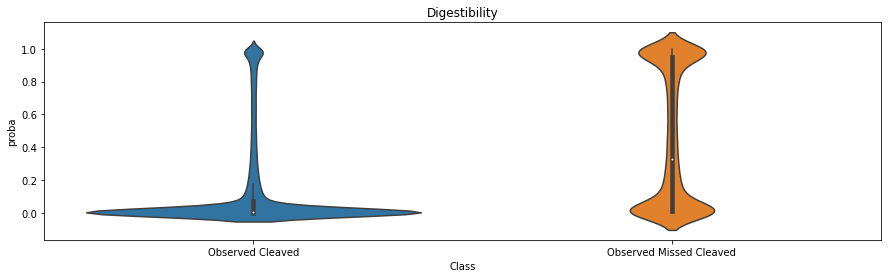

In [9]:
df_sns = pd.DataFrame(df_mers_onlyreal['proba'])
df_sns['Class']= df_mers_onlyreal.label.apply(lambda x: {1:'Observed Cleaved', 0:'Observed Missed Cleaved'}[x]).values

plt.figure(figsize=(15,4))
plt.title('Digestibility')
plt.ylabel('Digestibility')
plt.xlabel('Type')

sns.violinplot(data=df_sns, x='Class', y='proba', order=['Observed Cleaved', 'Observed Missed Cleaved'])
plt.show()

In [10]:
y_test = df_mers_onlyreal.label.values

              precision    recall  f1-score   support

           0       0.14      0.56      0.23     35745
           1       0.50      0.12      0.19    134200

    accuracy                           0.21    169945
   macro avg       0.32      0.34      0.21    169945
weighted avg       0.42      0.21      0.20    169945

rf auc : 0.23111407460820654


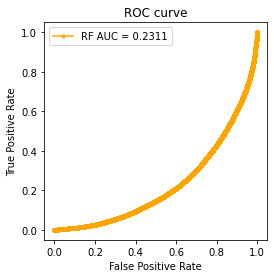

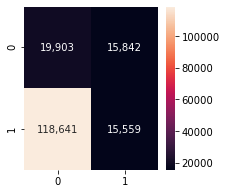

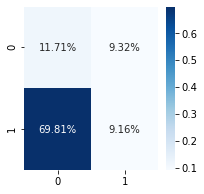

In [11]:
# prediction
y_pred = [1 if i>=0.5 else 0 for i in df_mers_onlyreal.proba.values]
print(classification_report(y_test, y_pred))

# AUC
probs = df_mers_onlyreal.proba.values
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# 아래는 아직 훈련덜끝났기에 3.6만개만 비교하는 임시코드

In [13]:
tmp = pd.read_csv('../data/df_detect_peptide_test.csv')

tp = set(tmp.PEP.unique())
testp = set(test.PEP.unique())
print(len(tp), len(testp), len(tp.intersection(testp)))

remain_tmp_p = tp.intersection(testp)
remain_idx = [idx for idx, p in zip(test.index, test.PEP.values) if p in remain_tmp_p]
remain_test = test.loc[remain_idx].reset_index(drop=True)

132645 66253 27389


In [14]:
en36 = pd.DataFrame([[ts, 1] for ts in remain_test.En.values], columns=['mers', 'label'])
ec36 = pd.DataFrame([[ts, 1] for ts in remain_test.Ec.values], columns=['mers', 'label'])
e136 = pd.DataFrame([[ts, 0] for ts in remain_test.E1.values], columns=['mers', 'label'])
e236 = pd.DataFrame([[ts, 0] for ts in remain_test.E2.values], columns=['mers', 'label'])
df_mers36 = pd.concat([en36, ec36, e136, e236], axis=0).reset_index(drop=True)

In [15]:
mers36 = df_mers36.mers.values
X_test36 = np.array(predictor.coding(mers36))
probas36 = loaded_model.predict(X_test36)
proba36 = [p[0] for p in probas36]

In [16]:
df_mers36['proba'] = proba36

(70653, 3) 63088


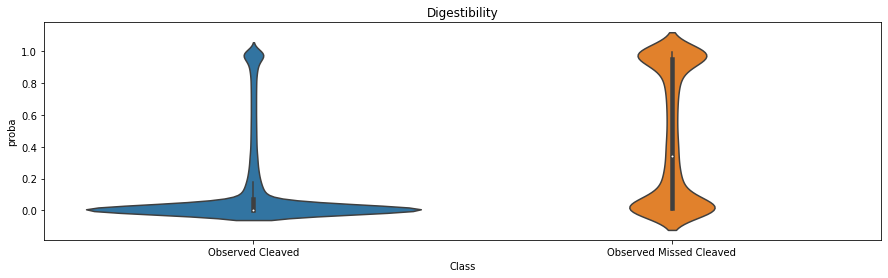

In [17]:
del_idx = [idx for idx, p in zip(df_mers36.index, df_mers36.mers.values) if p =='Z'*31]
df_mers_onlyreal36 = df_mers36.drop(del_idx, axis=0).reset_index(drop=True)

print(df_mers_onlyreal36.shape, len(df_mers_onlyreal36.mers.unique()))

df_sns = pd.DataFrame(df_mers_onlyreal36['proba'])
df_sns['Class']= df_mers_onlyreal36.label.apply(lambda x: {1:'Observed Cleaved', 0:'Observed Missed Cleaved'}[x]).values

plt.figure(figsize=(15,4))
plt.title('Digestibility')
plt.ylabel('Digestibility')
plt.xlabel('Type')

sns.violinplot(data=df_sns, x='Class', y='proba', order=['Observed Cleaved', 'Observed Missed Cleaved'])
plt.show()

# report

              precision    recall  f1-score   support

           0       0.14      0.55      0.22     14533
           1       0.50      0.12      0.19     56120

    accuracy                           0.21     70653
   macro avg       0.32      0.33      0.21     70653
weighted avg       0.43      0.21      0.20     70653

rf auc : 0.23050268298378027


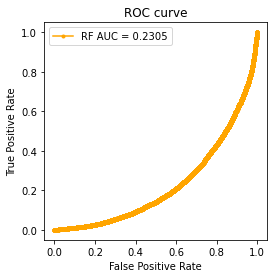

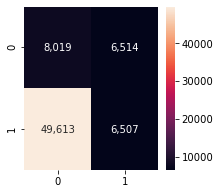

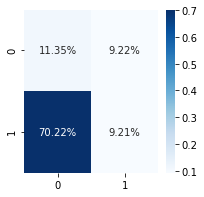

In [18]:
y_test = df_mers_onlyreal36.label.values

# prediction
y_pred = [1 if i>=0.5 else 0 for i in df_mers_onlyreal36.proba.values]
print(classification_report(y_test, y_pred))

# AUC
probs = df_mers_onlyreal36.proba.values
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()